In [3]:
import os
from PIL import Image
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torch
import torchvision.transforms as transforms
import numpy as np
path = "D:\Casper\OTHER\Data\MNIST2\HW2_MNIST_train"
dir_list = os.listdir(path)

# print(f"Files and directories in '{path}':")

0	0.7734375	0.4296875	0.21875	0.21875

(128, 128, 4)


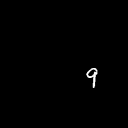

In [4]:
f = open(f"{path}/0000002.txt", "r")
print(f.read())
img = Image.open(f'{path}/0121744.png')
img = np.array(img)
print(img.shape)
img = Image.fromarray(img[:,:,2])
display(img)

In [5]:
img = Image.open(f'{path}/0121700.png')
r, g, b, trash = img.split()

r_array = np.array(r)
g_array = np.array(g)
b_array = np.array(b)

# Check if all channels have the same array values
are_channels_same = np.array_equal(r_array, g_array) and np.array_equal(g_array, b_array)
are_channels_same

True

In [6]:
import os
import pandas as pd
from torch.utils.data import Dataset
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, data_folder, transform=None):
        self.data_folder = data_folder
        self.image_files = [f for f in os.listdir(data_folder) if f.endswith(".png")]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.data_folder, self.image_files[idx])
        image = read_image(image_path)
        image = image[0:3].float()
        # image = image.reshape(1, 128, 128)
        
        txt_file = os.path.splitext(self.image_files[idx])[0] + ".txt"
        txt_path = os.path.join(self.data_folder, txt_file)
        with open(txt_path, "r") as f:
            first_line = f.readline().strip()
            class_label = int(first_line.split()[0])

        if self.transform:
            image = self.transform(image)

        return image, class_label
    
transform = transforms.Compose([
    # transforms.Resize((518, 518)),
                                ])
data_folder = path
custom_dataset = CustomImageDataset(data_folder, transform)


In [7]:
import random
from torch.utils.data import DataLoader, Subset
def get_dataloaders(data_folder, transform, train_ratio, val_ratio, batch_size):
    # Create a single merged dataset
    train_dataset = CustomImageDataset(data_folder, transform)
    val_dataset = CustomImageDataset(data_folder, transform)
    test_dataset = CustomImageDataset(data_folder, transform)

    # obtain training indices that will be used for validation
    num_train = len(test_dataset)
    indices = list(range(num_train))
    print("--------- INDEX checking ---------")
    print(f"Original: {indices[:5]}")
    random.shuffle(indices)
    print(f"Shuffled: {indices[:5]}")
    print("--------- INDEX shuffled ---------\n")

    split_train = int(np.floor(train_ratio * num_train))
    split_val = split_train + int(np.floor(val_ratio * (num_train-split_train)))
    train_idx, val_idx, test_idx = indices[0:split_train], indices[split_train:split_val], indices[split_val:]
    merge_dataset = Subset(train_dataset, train_idx)

    train_loader = DataLoader(merge_dataset, batch_size=batch_size)
    val_loader = DataLoader(Subset(val_dataset, val_idx), batch_size=batch_size)
    test_loader = DataLoader(Subset(test_dataset, test_idx), batch_size=batch_size)
    
    # check dataset
    print(f"Total number of samples: {num_train} datapoints")
    print(f"Number of train samples: {len(train_loader)} batches/ {len(train_loader.dataset)} datapoints")
    print(f"Number of val samples: {len(val_loader)} batches/ {len(val_loader.dataset)} datapoints")
    print(f"Number of test samples: {len(test_loader)} batches/ {len(test_loader.dataset)} datapoints")
    print(f"Data Transform: {transform}")
    print(f"")
    
    dataloaders = {
        "train": train_loader,
        "val": val_loader,
        "test": test_loader,
    }
    return dataloaders

In [9]:
loaders = get_dataloaders(data_folder, transform, 0, 1, 64)

--------- INDEX checking ---------
Original: [0, 1, 2, 3, 4]
Shuffled: [62101, 18620, 94004, 19872, 2395]
--------- INDEX shuffled ---------

Total number of samples: 97396 datapoints
Number of train samples: 0 batches/ 0 datapoints
Number of val samples: 1522 batches/ 97396 datapoints
Number of test samples: 0 batches/ 0 datapoints
Data Transform: Compose(
)



In [7]:
def count_parameters(model):
    total_num = 0
    for parameter in model.parameters():
        if parameter.requires_grad:
            total_num += parameter.numel() 
    return total_num


In [14]:
from datetime import datetime

def pprint(output = '\n', show_time = False): # print and fprint at the same time
    filename = "hw2-1-1-MAR24.txt"
    print(output)
    with open(filename, 'a') as f:
        if show_time:
            f.write(datetime.now().strftime("[%Y-%m-%d %H:%M:%S] "))

        f.write(str(output))
        f.write('\n')
pprint("OFFICIAL START, Focus on the 3rd problem", True)

OFFICIAL START, Focus on the 3rd problem


In [11]:
import time
from torch import nn, optim
from tqdm import tqdm

def train(model_lists, model_name):
    model = model_lists[model_name]()
    if 'res' in model_name:
        num_features = model.fc.in_features
        model.fc = torch.nn.Linear(num_features, 10)
    elif 'swin' in model_name:
        num_features = model.head.in_features
        model.head = torch.nn.Linear(num_features, 10)


    pprint(f"Training model: {model_name}", True)
    model_parameters_amount = count_parameters(model)
    pprint(f"Total parameters: {model_parameters_amount:,}")

    model = model.cuda()
    criterion = nn.CrossEntropyLoss()
    lr= 0.005
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.2)
    pprint(f"Learning rate={lr}")
    iteration = 0
    epochs = 25
    start = time.time()
    phases = ['train', 'val']
    for epoch in range(epochs):
        for phase in phases:
            running_loss = 0.0
            correct_predictions = 0
            correct_top3_predictions = 0
            total_samples = 0
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            for images, labels in tqdm(loaders[phase]): # Iterate over data.
                images, labels = images.cuda(), labels.cuda()
                outputs = model(images)
                loss = criterion(outputs, labels)

                with torch.set_grad_enabled(phase == 'train'):
                    if phase == 'train': # backward + optimize only if in training phase
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                        # scheduler.step()
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_predictions += (predicted == labels).sum().item()
                
                _, top3_preds = outputs.topk(3, 1, True, True)
                correct_top3_predictions += sum([labels[i] in top3_preds[i] for i in range(labels.size(0))])

                total_samples += labels.size(0)
                iteration += 1

            avg_loss = running_loss / total_samples
            top1_accuracy = correct_predictions / total_samples * 100
            top3_accuracy = correct_top3_predictions / total_samples * 100
            pprint(f"Epoch [{epoch+1}/{epochs}], phase: {phase}, samples: {total_samples}, Loss: {avg_loss:.4f}, Top-1 Accuracy: {top1_accuracy:.2f}%, Top-3 Accuracy: {top3_accuracy:.2f}%")
    end = time.time()
    duration = end - start
    pprint(f"Elapsed time: {duration} seconds")
    model_scripted = torch.jit.script(model) # Export to TorchScript
    model_scripted.save(f'{model_name}.pt') # Save
    pprint(f"weight saved as: {model_name}.pt")

In [ ]:
import torchvision.models as models

# model_lists = {
#     'resnet18': lambda: models.resnet18(weights=models.ResNet18_Weights.DEFAULT),
#     'resnet50': lambda: models.resnet50(weights=models.ResNet50_Weights.DEFAULT),
#     'resnet101': lambda: models.resnet101(weights=models.ResNet101_Weights.DEFAULT),
#     'resnet152': lambda: models.resnet152(weights=models.ResNet152_Weights.DEFAULT),
#     'swin_v2_t': lambda: models.swin_v2_t(weights=models.Swin_V2_T_Weights.DEFAULT),
#     'swin_v2_s': lambda: models.swin_v2_s(weights=models.Swin_V2_S_Weights.DEFAULT),
#     'swin_v2_b': lambda: models.swin_v2_b(weights=models.Swin_V2_B_Weights.DEFAULT),
# }

# model_names = [
#     'resnet18',
#     'resnet50',
#     'resnet101',
#     'resnet152',
#     'swin_v2_t',
#     'swin_v2_s',
#     'swin_v2_b',
# ]
# for model_name in model_names:
#     train(model_lists, model_name)

In [1]:
def majority_voting(output_list):
    stacked_outputs = torch.stack(output_list)
    avg_probs = torch.mean(stacked_outputs, dim=0)
    
    return avg_probs

In [10]:
import time
from torch import nn, optim
from tqdm import tqdm

def eval(model_list):
    for model in model_list:
        model.cuda()
        model.eval()
    criterion = nn.CrossEntropyLoss()
    start = time.time()
    phases = ['val']
    num_class = 10
    for phase in phases:
        running_loss = 0.0
        correct_predictions = 0
        correct_top3_predictions = 0
        total_samples = 0
        confus = torch.zeros(num_class, num_class,dtype=int)            
        for images, labels in tqdm(loaders[phase]): # Iterate over data.
            images, labels = images.cuda(), labels.cuda()
            model_outputs = []
            for model in model_list:
                with torch.no_grad():
                    outputs = model(images)
                    model_outputs.append(outputs)
            vote_outputs = majority_voting(model_outputs)
            loss = criterion(vote_outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(vote_outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            
            _, top3_preds = outputs.topk(3, 1, True, True)
            correct_top3_predictions += sum([labels[i] in top3_preds[i] for i in range(labels.size(0))])
            total_samples += labels.size(0)

            for ii in range(len(predicted)):
                confus[ labels.data[ii] ][ predicted[ii] ]+=1

        avg_loss = running_loss / total_samples
        top1_accuracy = correct_predictions / total_samples * 100
        top3_accuracy = correct_top3_predictions / total_samples * 100
        pprint(f"Phase: {phase}, samples: {total_samples}, Loss: {avg_loss:.4f}, Top-1 Accuracy: {top1_accuracy:.2f}%, Top-3 Accuracy: {top3_accuracy:.2f}%")
        for ii in range(num_class) :
            pprint(f"class {ii}:{confus.numpy()[ii]}")
        # pprint(confus)

    end = time.time()
    duration = end - start
    pprint(f"Elapsed time: {duration} seconds")

# HW2-1-1

In [16]:
import torchvision.models as models
path = "D:\\Casper\\aML\\HW2\\"
path2 = "D:\\Casper\\aML\\HW2\\"
model_list = [
    torch.jit.load(f'{path}resnet152_hw1_99.87268470984435.pt'),
    torch.jit.load(f'{path}resnet152_hw1_99.7576902542199.pt'),
    torch.jit.load(f'{path}resnet152_hw1_99.8398291510945.pt'),
    torch.jit.load(f'{path}resnet152_hw1_99.79362602160253.pt'),
    torch.jit.load(f'{path}resnet152_hw1_99.81621421824305.pt'),
]

# model_name = [
#     'resnet152',
# ]
eval(model_list)

100%|██████████| 1522/1522 [05:21<00:00,  4.74it/s]

Phase: val, samples: 97396, Loss: 0.0000, Top-1 Accuracy: 99.96%, Top-3 Accuracy: 100.00%
class 0:[10785     0     0     0     0     0     0     0     0     0]
class 1:[    0 10826     0     0     3     0     0     6     0     0]
class 2:[   0    0 9529    0    0    0    0    2    0    0]
class 3:[   0    0    1 9809    0    1    0    0    1    0]
class 4:[   0    0    0    0 9312    0    0    1    0    1]
class 5:[   0    0    0    2    0 8683    2    0    0    0]
class 6:[   1    2    0    1    0    1 9469    0    0    0]
class 7:[    0     0     0     0     0     0     0 10007     0     0]
class 8:[   0    0    1    0    0    0    0    0 9425    1]
class 9:[   0    0    0    0    7    0    0    1    0 9516]
Elapsed time: 321.2854561805725 seconds


# HW2-1-2

In [26]:

loaders = get_dataloaders(data_folder, transform, 1, 0.5, 1)
model2_1_2 = torch.jit.load(f'D:\\Casper\\aML\\HW2\\OneParaModel.pt')

def evaluation(model, data_loader):

    correct = 0
    total = 0

    print(f"")
    model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader):
            outputs = model(inputs)
            total += labels.size(0)
            correct += (outputs == labels).sum().item()
    accuracy = correct / total
    print(f"Total accuracy: {accuracy*100:.2f}%")
evaluation(model2_1_2, loaders['train'])
    

0it [00:00, ?it/s]


ZeroDivisionError: division by zero

# HW2-1-3


In [27]:
# def predict_folder_images(folder_path, model, output_csv_path):
#     # Ensure the model is in evaluation mode
#     model.eval()

#     # Define the transformation for the input images
#     transform = transforms.Compose([
#         # transforms.Resize((224, 224)),  # Resize images
#         transforms.ToTensor(),  # Convert to tensor
#         # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
#     ])
    
#     results = []

#     # Loop through all PNG files in the folder
#     for filename in os.listdir(folder_path):
#         if filename.endswith('.png'):
#             # Construct the full path to the image file
#             file_path = os.path.join(folder_path, filename)
            
#             # Load and transform the image
#             image = Image.open(file_path).convert('RGB')
#             image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
                        
#             model_outputs = []
#             for model in model_list:
#                 with torch.no_grad():
#                     outputs = model(image_tensor)
#                     model_outputs.append(outputs)
#             vote_outputs = majority_voting(model_outputs)
#             _, predicted = torch.max(vote_outputs, 1)

#             # Save the filename and the predicted class
#             results.append([filename, predicted])

#     # Write results to a CSV file
#     with open(output_csv_path, 'w', newline='') as csvfile:
#         writer = csv.writer(csvfile)
#         writer.writerow(['image', 'class'])  # Write the header
#         writer.writerows(results)

# folder_path = 'D:\\Casper\\OTHER\\Data\\MNIST2\\HW2_MNIST_test'
# output_csv_path = 'predictions.csv'
# model = torch.jit.load(f'{path}resnet152_hw1_99.87268470984435.pt')
# predict_folder_images(folder_path, model, output_csv_path)

RuntimeError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript, serialized code (most recent call last):
  File "code/__torch__/torchvision/models/resnet.py", line 22, in forward
  def forward(self: __torch__.torchvision.models.resnet.ResNet,
    x: Tensor) -> Tensor:
    return (self)._forward_impl(x, )
            ~~~~~~~~~~~~~~~~~~~ <--- HERE
  def _forward_impl(self: __torch__.torchvision.models.resnet.ResNet,
    x: Tensor) -> Tensor:
  File "code/__torch__/torchvision/models/resnet.py", line 26, in _forward_impl
    x: Tensor) -> Tensor:
    conv1 = self.conv1
    x0 = (conv1).forward(x, )
          ~~~~~~~~~~~~~~ <--- HERE
    bn1 = self.bn1
    x1 = (bn1).forward(x0, )
  File "code/__torch__/torch/nn/modules/conv.py", line 23, in forward
    weight = self.weight
    bias = self.bias
    _0 = (self)._conv_forward(input, weight, bias, )
          ~~~~~~~~~~~~~~~~~~~ <--- HERE
    return _0
  def _conv_forward(self: __torch__.torch.nn.modules.conv.Conv2d,
  File "code/__torch__/torch/nn/modules/conv.py", line 29, in _conv_forward
    weight: Tensor,
    bias: Optional[Tensor]) -> Tensor:
    _1 = torch.conv2d(input, weight, bias, [2, 2], [3, 3], [1, 1])
         ~~~~~~~~~~~~ <--- HERE
    return _1

Traceback of TorchScript, original code (most recent call last):
  File "c:\Users\User\anaconda3\envs\GPU\lib\site-packages\torchvision\models\resnet.py", line 285, in forward
    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)
               ~~~~~~~~~~~~~~~~~~ <--- HERE
  File "c:\Users\User\anaconda3\envs\GPU\lib\site-packages\torchvision\models\resnet.py", line 268, in _forward_impl
    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
            ~~~~~~~~~~ <--- HERE
        x = self.bn1(x)
        x = self.relu(x)
  File "c:\Users\User\anaconda3\envs\GPU\lib\site-packages\torch\nn\modules\conv.py", line 460, in forward
    def forward(self, input: Tensor) -> Tensor:
        return self._conv_forward(input, self.weight, self.bias)
               ~~~~~~~~~~~~~~~~~~ <--- HERE
  File "c:\Users\User\anaconda3\envs\GPU\lib\site-packages\torch\nn\modules\conv.py", line 456, in _conv_forward
                            weight, bias, self.stride,
                            _pair(0), self.dilation, self.groups)
        return F.conv2d(input, weight, bias, self.stride,
               ~~~~~~~~ <--- HERE
                        self.padding, self.dilation, self.groups)
RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor
